## Resources on PLY

 
## Documentation of PLY is here: https://www.dabeaz.com/ply/ply.html
 

## This Youtube video is a talk by David Beazley, the author of PLY

In [ ]:
from IPython.display import YouTubeVideo
# Direct path is https://youtu.be/zJ9z6Ge-vXs
YouTubeVideo('zJ9z6Ge-vXs')

 ## This Youtube video is a talk on creating a calculator using PLY
 

In [ ]:
from IPython.display import YouTubeVideo
# Direct path is  https://youtu.be/Hh49BXmHxX8
YouTubeVideo('Hh49BXmHxX8')

# THIS NOTEBOOK is referenced in Asg-6
# It Creates a RegExp Parser + Draw Parse Trees

# YOUR QUESTIONS are at the end!

In [1]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
import sys

# -- Detect if in Own Install or in Colab
try:
    import google.colab
    OWN_INSTALL = False
except:
    OWN_INSTALL = True
    
if OWN_INSTALL:
    
  #---- Leave these definitions ON if running on laptop
  #---- Else turn OFF by putting them between ''' ... '''

  sys.path[0:0] = ['../../../../..',  '../../../../../3rdparty',  
                   '../../../..',  '../../../../3rdparty',  
                   '../../..',     '../../../3rdparty', 
                   '../..',        '../../3rdparty',
                   '..',           '../3rdparty' ]

else: # In colab
  ! if [ ! -d Jove ]; then git clone https://github.com/ganeshutah/Jove Jove; fi
  sys.path.append('./Jove')
  sys.path.append('./Jove/jove')

# -- common imports --
from jove.lex import lex
from jove.yacc import yacc

from jove.StateNameSanitizers import ResetStNum, NxtStateStr
from jove.SystemImports       import *

from jove.Def_NFA import mk_nfa
from jove.DotBashers import *

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Cloning into 'Jove'...
remote: Enumerating objects: 6011, done.
remote: Counting objects: 100% (1377/1377), done.
remote: Compressing objects: 100% (574/574), done.
remote: Total 6011 (delta 792), reused 1324 (delta 748), pack-reused 4634
Receiving objects: 100% (6011/6011), 9.13 MiB | 22.15 MiB/s, done.
Resolving deltas: 100% (3797/3797), done.
You may use any of these help commands:
help(ResetStNum)
help(NxtStateStr)

You may use any of these help commands:
help(mkp_dfa)
help(mk_dfa)
help(totalize_dfa)
help(addtosigma_delta)
help(step_dfa)
help(run_dfa)
help(accepts_dfa)
help(comp_dfa)
help(flTup)
help(union_dfa)
help(intersect_dfa)
help(pruneUnreach)
help(iso_dfa)
help(langeq_dfa)
help(same_status)
help(h_langeq_dfa)
help(fixptDist)
help(min_dfa)
help(pairFR)
help(state_combos)
help(sepFinNonFin)
help(bash_eql_classes)
help(listminus)
help(bash_1)
help(mk_rep_eqc)
help(F_of)
help(rep_of_s)
help(q0_of)
help(Delta_of)
help(mk_state_eqc_name)

You may use any of these help commands:
he

In [2]:
tokens = ('EPS','STR','LPAREN','RPAREN','PLUS','STAR')  

# Tokens in our RE are these
t_EPS     = r'\'\'|\"\"'  # Not allowing @ for empty string anymore! # t_EPS = r'\@'

# The following allows one lower-case, one upper-case or one digit to be used in our REs
t_STR     = r'[a-zA-Z0-9]'

t_LPAREN  = r'\('
t_RPAREN  = r'\)'

t_PLUS    = r'\+'
t_STAR    = r'\*'



# Ignored characters
t_ignore = " \t"

def t_newline(t):
    r'\n+'
    t.lexer.lineno += t.value.count("\n")
    
def t_error(t):
    print("Illegal character '%s'" % t.value[0])
    t.lexer.skip(1)
    

def p_expression_plus(t):
    'expression : expression PLUS catexp'
    #
    nfa = mk_plus_nfa(t[1]['nfa'], t[3]['nfa']) # Union of the two NFAs is returned
    tree = attrDyadicInfix("+", t[1], t[3])
    tree.update({'nfa':nfa})
    t[0] = tree
    

def p_expression_plus1(t):
    'expression : catexp'
    #
    t[0] = t[1]  

def p_expression_cat(t):
    'catexp :  catexp ordyexp'
    #
    nfa = mk_cat_nfa(t[1]['nfa'], t[2]['nfa'])
    #--insert new field 'nfa'
    tree = attrDyadicInfix(".", t[1], t[2])
    tree.update({'nfa':nfa})
    t[0] = tree

def p_expression_cat1(t):
    'catexp :  ordyexp'
    #
    t[0] = t[1] 

# We employ field 'ast' of the dict to record the abstract syntax tree. 
# Field 'dig' holds a digraph. It too is a dict. 
# Its fields are nl for the node list and el for the edge list

def p_expression_ordy_star(t):
    'ordyexp : ordyexp STAR'
    #
    nfa = mk_star_nfa(t[1]['nfa'])
    
    ast = ('*', t[1]['ast'])
    nlin = t[1]['dig']['nl']
    elin = t[1]['dig']['el']
    
    rootin = nlin[0]

    root = NxtStateStr("R*_") 
    right = NxtStateStr("*_")

    t[0] = {'nfa' : nfa,
            'ast' : ast,
            'dig' : {'nl' : [root] + nlin + [right], # this order important for proper layout!
                     'el' : elin + [ (root, rootin),
                                     (root, right) ]
                    }}
    
def p_expression_ordy_paren(t):
    'ordyexp : LPAREN expression RPAREN'
    #
    nfa  = t[2]['nfa']
    
    ast  = t[2]['ast']
    nlin = t[2]['dig']['nl']
    elin = t[2]['dig']['el']
    
    rootin = nlin[0]
    
    root = NxtStateStr("(R)_")
    left = NxtStateStr("(_")
    right= NxtStateStr(")_")
    
    t[0] = {'nfa' : nfa,
            'ast' : ast,
            'dig' : {'nl' : [root, left] + nlin + [right], #order important f. proper layout!
                     'el' : elin + [ (root, left),
                                     (root, rootin),
                                     (root, right) ]
                    }}
    
def p_expression_ordy_eps(t):
    'ordyexp : EPS'
    #
    strn = '@'
    ast  = ('@', strn)           
    t[0] = { 'nfa' : mk_eps_nfa(),
             'ast' : ast,
             'dig' : {'nl' : [ strn + NxtStateStr("_") ],
                      'el' : []
                     }} 
    
def p_expression_ordy_str(t):
    'ordyexp : STR'
    #
    str = t[1]
    nfa_STR = mk_symbol_nfa(t[1])
    ast  = ('str', str)
    t[0] = {'nfa' : nfa_STR,
            'ast' : ast,
            'dig' : {'nl' : [ str + NxtStateStr("_") ],
                     'el' : [] 
                    }}
    
def p_error(t):
    print("Syntax error at '%s'" % t.value)

#--
def parseRE(s):
    """In: a string s containing a regular expression.
       Out: An attribute quadruple (nfa,ast,nodelist,edgelist)        
    """
    mylexer  = lex()
    myparser = yacc()
    #-- pass the right lexer into the parser    
    p = myparser.parse(s, lexer = mylexer)  
    return (p['nfa'], p['ast'], p['dig']['nl'], p['dig']['el']) 

#--
def mk_plus_nfa(N1, N2):
    """Given two NFAs, return their union.
    """
    delta_accum = dict({})
    delta_accum.update(N1["Delta"])
    delta_accum.update(N2["Delta"]) # Simply accumulate the transitions
    # The alphabet is inferred bottom-up; thus we must union the Sigmas 
    # of the NFAs!
    return mk_nfa(Q     = N1["Q"] | N2["Q"], 
                  Sigma = N1["Sigma"] | N2["Sigma"], 
                  Delta = delta_accum, 
                  Q0    = N1["Q0"] | N2["Q0"], 
                  F     = N1["F"] | N2["F"])  

def mk_cat_nfa(N1, N2):
    '''Given two NFAs, return their concatenation.
    '''
    delta_accum = dict({}) 
    delta_accum.update(N1["Delta"])
    delta_accum.update(N2["Delta"])
    # Now, introduce moves from every one of N1's final states
    # to the set of N2's initial states.
    for f in N1["F"]:
        # However, N1's final states may already have epsilon moves to
        # other N1-states!
        # Expand the target of such jumps to include N2's Q0 also!
        if (f, "") in N1["Delta"]: 
            delta_accum.update({ (f,""):(N2["Q0"] | N1["Delta"][(f, "")])
                               })
        else:
            delta_accum.update({ (f, ""): N2["Q0"] })
    # In syntax-directed translation, it is impossible
    # that N2 and N1 have common states. Check anyhow
    # in case there are bugs elsewhere that cause it.
    assert((N2["F"] & N1["F"]) == set({})) 
    return mk_nfa(Q     = N1["Q"] | N2["Q"], 
                  Sigma = N1["Sigma"] | N2["Sigma"], 
                  Delta = delta_accum, 
                  Q0    = N1["Q0"],
                  F     = N2["F"])


def mk_star_nfa(N):
    '''Given an NFA, make its star.
    '''
    # Follow construction from Kozen's book:
    # 1) Introduce new (single) start+final state IF
    # 2) Let Q0 = set({ IF })
    # 2) Move on epsilon from IF to the set N[Q0]
    # 3) Make N[F] non-final
    # 4) Spin back from every state in N[F] to Q0
    #
    delta_accum = dict({})
    IF = NxtStateStr()
    Q0 = set({ IF }) # new set of start + final states
    # Jump from IF to N's start state set
    delta_accum.update({ (IF,""): N["Q0"] })
    delta_accum.update(N["Delta"])
    #
    for f in N["F"]:
        # N's final states may already have epsilon moves to
        # other N-states!
        # Expand the target of such jumps to include Q0 also.
        if (f, "") in N["Delta"]:
            delta_accum.update({ (f, ""): (Q0 | N["Delta"][(f, "")]) })
        else:
            delta_accum.update({ (f, ""): Q0 })
    #
    return mk_nfa(Q     = N["Q"] | Q0, 
                  Sigma = N["Sigma"], 
                  Delta = delta_accum, 
                  Q0    = Q0, 
                  F     = Q0)


def mk_eps_nfa():
    """An nfa with exactly one start+final state, which is the NFA for Epsilon.
    """
    Q0 = set({ NxtStateStr() })
    F  = Q0
    return mk_nfa(Q     = Q0, 
                  Sigma = set({}), 
                  Delta = dict({}), 
                  Q0    = Q0, 
                  F     = Q0)                      

def mk_symbol_nfa(a):
    """The NFA for a single re letter.
    """
    # Make a fresh initial state
    q0 = NxtStateStr()
    Q0 = set({ q0 })
    # Make a fresh final state
    f = NxtStateStr()
    F = set({ f })
    return mk_nfa(Q     = Q0 | F, 
                  Sigma = set({a}), 
                  Delta = { (q0,a): F },
                  Q0    = Q0, 
                  F     = F)
                                                        

In [3]:
def attrDyadicInfix(op, attr1, attr3):         # <== this is what prints the parse-tree
    ast  = (op, (attr1['ast'], attr3['ast']))  # <== for an infix operator
    
    nlin1 = attr1['dig']['nl']
    nlin3 = attr3['dig']['nl']
    nlin  = nlin1 + nlin3
    
    elin1 = attr1['dig']['el']
    elin3 = attr3['dig']['el']
    elin  = elin1 + elin3
    
    rootin1 = nlin1[0]
    rootin3 = nlin3[0]    
    
    root   = NxtStateStr("R1"+op+"R2"+"_") # NxtStateStr("$_")
    left   = rootin1
    middle = NxtStateStr(op+"_")
    right  = rootin3
    
    return {'ast' : ast,
            'dig' : {'nl' : [ root, left, middle, right ] + nlin,
                     'el' : elin + [ (root, left),
                                     (root, middle),
                                     (root, right) ]
                     }}


def drawPT(nfa_ast_nl_el, comment="PT"):
    """Given an (nfa, ast, nl, el) quadruple where nl is the node and el the edge-list,
       draw the Parse Tree by returning a dot object. Also return the NFA dot object.
    """
    (nfa, ast, nl, el) = nfa_ast_nl_el
    print("Drawing AST for ", ast)
    dotObj_pt = Digraph(comment)
    dotObj_pt.graph_attr['rankdir'] = 'TB'
    for n in nl:
        prNam = n.split('_')[0]
        dotObj_pt.node(n, prNam, shape="oval", peripheries="1")
    for e in el:
        dotObj_pt.edge(e[0], e[1])
    return (dotObj_nfa(nfa), dotObj_pt)

# Now answer these questions

In [4]:
parseRE("''")

Generating LALR tables


({'Q': {'St1'}, 'Sigma': set(), 'Delta': {}, 'Q0': {'St1'}, 'F': {'St1'}},
 ('@', '@'),
 ['@_2'],
 [])

In [5]:
(n,t) = drawPT(parseRE("''"))

Drawing AST for  ('@', '@')


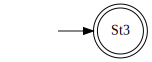

In [6]:
n

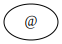

In [7]:
t

In [8]:
(n1,t1) = drawPT(parseRE("(a*b*+cc)*"))

Drawing AST for  ('*', ('+', (('.', (('*', ('str', 'a')), ('*', ('str', 'b')))), ('.', (('str', 'c'), ('str', 'c'))))))


In [9]:
(n2,t2) = drawPT(parseRE("(a*b)*+cc*"))

Drawing AST for  ('+', (('*', ('.', (('*', ('str', 'a')), ('str', 'b')))), ('.', (('str', 'c'), ('*', ('str', 'c'))))))


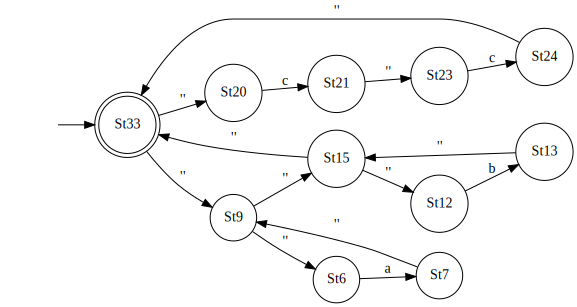

In [10]:
n1

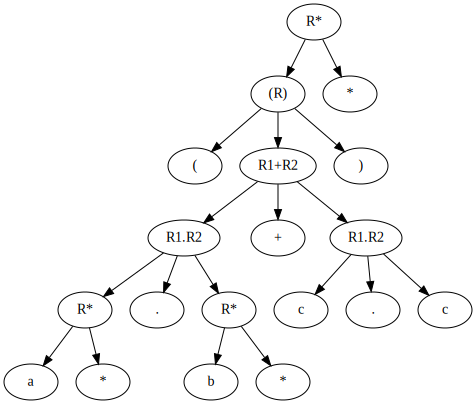

In [11]:
t1

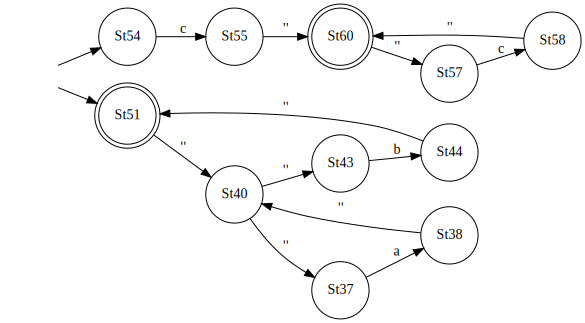

In [12]:
n2

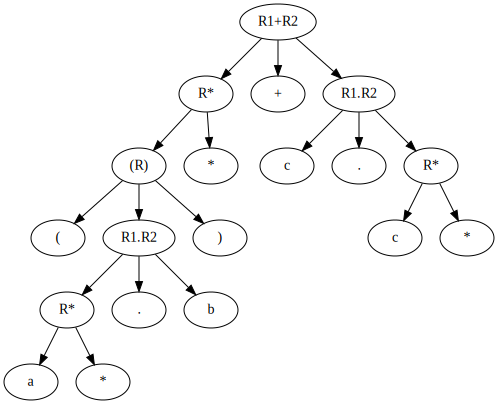

In [13]:
t2


# YOUR QUESTIONS 

# Q1: Run this notebook as follows

## 1) Restart this notebook if you want a "fresh" look. Then remove the parsetab.py file and the  __pycache__/ folder, again if things are confusing (else, no need). These are found under the "File Icon" tab on Colab (click to expand that icon on the left, and then nuke those files/folders and rerun the notebook). Again these are not essential steps for the most part - but good to do in case the remaining steps in this notebook give you trouble.

## 2) Run all the cells (ignore warnings such as this)

#### WARNING: ../../../../jove/TransitionSelectors.py:22: Possible grammar rule 'fn_range' defined without p_ prefix

## 3) Look at the productions (the ```p_``` functions) present earlier in this notebook (example: p_expression_plus, and then the others after it) and write down a context-free grammar for parsing regular expressions that has been encoded in this Jove notebook.

### YOUR ANSWER may please be written in this style, (inventing suitable abbreviations to express the High-level Rule)

* expression : expression PLUS catexpression
  - High-level Rule: R -> R + C  
  
* Do this for all the rules

* When you have things like LPAREN, look up how the token was encoded, and write `(` instead in the High-level Rule. This way, things become a bit more readable than just seeing LPAREN, RPAREN, etc.

* In summary, for this "Q1" part of the answer under Question 3, your are to produce a neat-looking CFG which consists of high-level rules as above. By looking at those collection of rules, one should see clearly how we have specified the grammar for regular expression-parsing.



# Q2: Execute these commands:

* (n1,t1) = ```drawPT(parseRE("(a*b*+cc)*"))```

* (n2,t2) = ```drawPT(parseRE("(a*b)*+cc*"))```

## By comparing n1 and t1, justify that the correct NFA formation rules have been followed. Repeat for n2 and t2. YOUR JUSTIFICATION must consist of EXACTLY the following two sentencs with the details filled in.


1) *I observe that the root node for the first regular expression (RE) is SUCH AND SUCH and that is because the RE was parsed as by applying the STAR operator a, and then b, and finally to FILL THIS PART SHOWING WHICH sub-regular-expression the third STAR operator was applied to.*

2) *For the second RE, the last STAR was applied to DESCRIBE IN ONE SENTENCE.*

3) *I acknowledge that I now fully understand how parseRE works. And I can see the same method being usd in file Def_RE2NFA.py in the jove/ folder of Jove. In both cases, the parse() function depends on a parser generated as per identical context-free grammar rules.*

**For this step, you must click on the file icon, find the Jove files on the left-tab, locate Def_RE2NFA.py, download that file, and take a look inside that file. Thus your answer merely is the I acknowledge part, but you must have done these steps! We trust you, as we believe you want to learn these practical matters (you may be quizzed later in an actual exam to check if you did this).**



# Q3: Explain the workings of mk_star_nfa. 


## *REQUIRED ANSWER*: 

## EXPLAIN HOW the code below for mk_star_nfa takes the NFA for ```R``` and produces an NFA for ```R*```.  The code you paste below can vary - but do pick up related code and paste below.

   1) Introduce new (single) start+final state IF.Let Q0 = set({ IF }). THIS HAPPENS in THESE LINES OF CODE (paste the lines of code involved)

    HERE

   2) Move on epsilon from IF to the set N[Q0].

   THIS HAPPENS in THESE LINES OF CODE (paste the lines of code involved)

    HERE

  3) Make N[F] non-final.

  THIS HAPPENS in THESE LINES OF CODE (paste the lines of code involved)

    HERE

  4) Spin back from every state in N[F] to Q0.

  THIS HAPPENS in THESE LINES OF CODE (paste the lines of code involved)

    HERE

  5) Return the final NFA.

     HERE

```
def mk_star_nfa(N):
    '''Given an NFA, make its star.
    '''
    #
    delta_accum = dict({})
    IF = NxtStateStr()
    Q0 = set({ IF }) # new set of start + final states
    # Jump from IF to N's start state set
    delta_accum.update({ (IF,""): N["Q0"] })
    delta_accum.update(N["Delta"])
    #
    for f in N["F"]:
        # N's final states may already have epsilon moves to
        # other N-states!
        # Expand the target of such jumps to include Q0 also.
        if (f, "") in N["Delta"]:
            delta_accum.update({ (f, ""): (Q0 | N["Delta"][(f, "")]) })
        else:
            delta_accum.update({ (f, ""): Q0 })
    #
    return mk_nfa(Q     = N["Q"] | Q0, 
                  Sigma = N["Sigma"], 
                  Delta = delta_accum, 
                  Q0    = Q0, 
                  F     = Q0)
                  ```

